<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python
#pip install tensorflow      # keras is run on tensorflow so install tensorflow first
# vv 
#pip install keras

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os
from os import listdir

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers

from keras.wrappers.scikit_learn import KerasClassifier
from tune_sklearn import TuneGridSearchCV

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

# <h2>STEP 1.2 : Note ( It's not necessary to use. )</h2>

In [6]:
# get the path/directory

Zero_dir = main_dir + "/0"

#for images in os.listdir(One_dir):
 
    # check if the image ends with png
#    if (images.endswith(".png")):
#        print(images)

Original Image Shape (28, 28, 3)


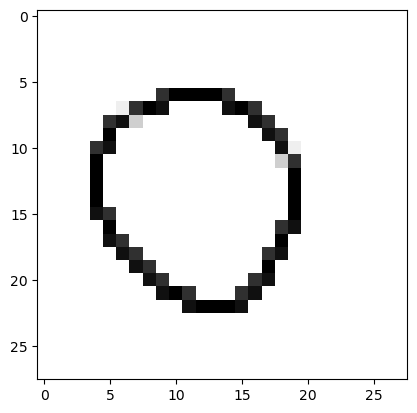

In [7]:
#To read the image 
bgrimg = cv2.imread(str(Zero_dir+'/0-2.png'))

plt.imshow(bgrimg)

#To get rid of the x-ticks and y-ticks on the image axis
#plt.xticks([])
#plt.yticks([])

print('Original Image Shape',bgrimg.shape)

In [8]:
#cv2.imread(str(Zero_dir+'/IMG_0953.png'))

# STEP 2 : Preparing & inspection

Prepare for inspections

In [9]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [10]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\2\IMG_0880.png,2
1,./Thainumber\3\3-1.png,3
2,./Thainumber\1\1.3.png,1
3,./Thainumber\0\IMG_0956.png,0
4,./Thainumber\4\IMG_0901.png,4
...,...,...
295,./Thainumber\3\3-51.png,3
296,./Thainumber\0\zero7.png,0
297,./Thainumber\1\one6.png,1
298,./Thainumber\6\IMG_0914.png,6


In [11]:
data.shape

(300, 2)

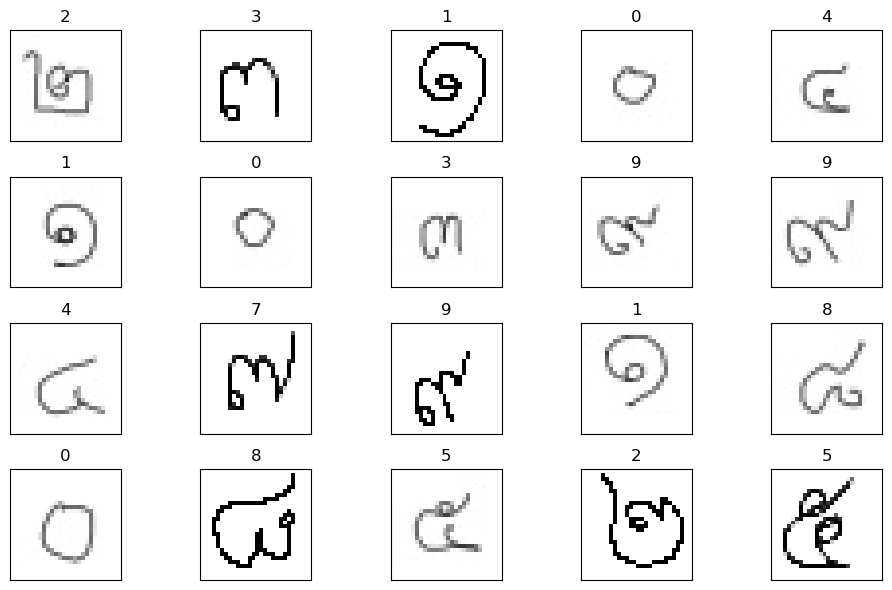

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

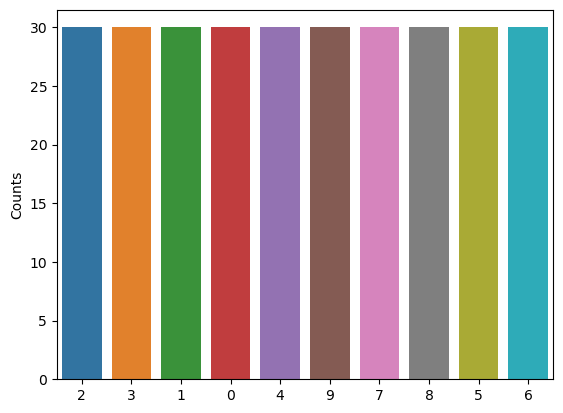

In [13]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [14]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    img_arr = cv2. cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img_arr = np.expand_dims(img_arr, 2)
    read_x.append(img_arr)

Almost_x = np.array(read_x)
x = Almost_x/255       # Devide by 255 is to Normalization

In [15]:
print( y.unique(), '\n' )

# Binarize the output

y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
print(y)

['2' '3' '1' '0' '4' '9' '7' '8' '5' '6'] 

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
X_train, X_test , y_train, y_test = train_test_split( x, y , test_size=0.3, random_state=42 )

print('Train shape =>',X_train.shape , X_test.shape)
print('Test shape =>',y_train.shape , y_test.shape )

Train shape => (210, 28, 28, 1) (90, 28, 28, 1)
Test shape => (210, 10) (90, 10)


# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [6]:
from pycaret.classification import *

s = setup(data, target = 'Label', session_id = 123)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
best = s.compare_models( )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:19:13
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
best

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

<h4>Cross Validation : keras</h4>
By : TuneGridSearchCV

Build a Neural Network model for cross validation <br>
E.g set hidden layers , etc.

In [ ]:
# Set up model

def create_model(optimizer="rmsprop", kernel_initializer="glorot_uniform"):
    model = keras.Sequential()
    model.add(layers.Dense(100, input_shape=(28,28,1 )))
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, kernel_initializer=kernel_initializer))
    model.add(layers.Activation("relu"))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, kernel_initializer=kernel_initializer))
    model.add(layers.Activation("softmax"))  # This special "softmax" a
    model.compile(
        loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


In [ ]:
model = KerasClassifier(build_fn=create_model)
optimizers = ["rmsprop", "adam"]
kernel_initializer = ["glorot_uniform", "normal"]
epochs = [10, 20]
param_grid = dict(
    optimizer=optimizers,
    nb_epoch=epochs,
    kernel_initializer=kernel_initializer)

grid = TuneGridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.cv_results_)

(_Trainable pid=18856) 
(_Trainable pid=18856) 1/6 [====>.........................] - ETA: 6s - loss: 0.7191 - accuracy: 0.1562
(_Trainable pid=18856) 2/6 [=========>....................] - ETA: 0s - loss: 0.8975 - accuracy: 0.1719
(_Trainable pid=18856) 3/6 [==============>...............] - ETA: 0s - loss: 0.7998 - accuracy: 0.1354
(_Trainable pid=18856) 4/6 [===================>..........] - ETA: 0s - loss: 0.7004 - accuracy: 0.1250
(_Trainable pid=18856) 5/6 [========================>.....] - ETA: 0s - loss: 0.6325 - accuracy: 0.1125
(_Trainable pid=18856) 6/6 [==============================] - 2s 144ms/step - loss: 0.6174 - accuracy: 0.1071
(_Trainable pid=680) 6/6 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.0893
(_Trainable pid=3540)  [repeated 65x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more option

(_Trainable pid=18856) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022696ACC700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(_Trainable pid=18856) 2/6 [=========>....................] - ETA: 0s - loss: 0.9509 - accuracy: 0.1250  [repeated 10x across cluster]
(_Trainable pid=18856) 1/2 [==============>...............] - ETA: 0s - loss: 0.3730 - accuracy: 0.0312 [repeated 21x across cluster]
(_Trainable pid=18856) 4/6 [===================>..........] - ETA: 0s - loss: 0.7662 - accuracy: 0.0859 [repeated 9x across cluster]
(_Trainable pid=18856) 5/6 [========================>.....] - ETA: 0s - loss: 0.6823 - accuracy: 0.0938 [repeated 9x across cluster]
(_Trainable pid=18856) 2/2 [==============================] - 0s 11ms/step - loss: 0.3705 - accuracy: 0.0476 [repeated 18x across cluster]
(_Trainable pid=13704) 6/6 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.1310 [repeated 4x across cluster]
7/7 [==============================] - 1s 59ms/step - loss: 0.5040 - accuracy: 0.1286
{'optimizer': 'adam', 'nb_epoch': 20, 'kernel_initializer': 'glorot_uniform'}
{'params': [{'optimizer': 'rm

# STEP 4 : Test